<a href="https://colab.research.google.com/github/okolenchuk/Hymenoptera_convolution/blob/main/Hymenoptera_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip;
!unzip hymenoptera_data.zip;

--2022-09-04 16:42:28--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.90, 13.226.52.51, 13.226.52.128, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  66.6MB/s    in 0.7s    

2022-09-04 16:42:28 (66.6 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/t

In [2]:
import numpy as np
import torch
import torch.nn as nn
import os
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
from tqdm.autonotebook import trange, tqdm


use_gpu = torch.cuda.is_available()
use_gpu

False

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class Resnet18Custom(nn.Module):
    def __init__(self, block, layers, n_classes = 10):
        super(Resnet18Custom, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, n_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [5]:
class VGG16Custom(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1))


        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)

        return x

In [6]:
# read and transform dataset, make dataloaders

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [7]:
print(dataset_sizes)

{'train': 244, 'val': 153}


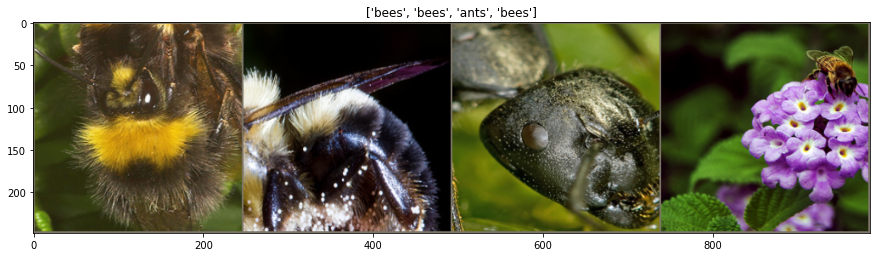

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    if use_gpu:
      model.cuda()

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [10]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [11]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [12]:
resnet18_cus = Resnet18Custom(ResidualBlock, [3, 4, 6, 3], n_classes=2)

vgg16custom = VGG16Custom(n_classes=2)

resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, 2)

vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [13]:
resnet18_cus

Resnet18Custom(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [14]:
#training resnet18 custom

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(resnet18_cus.parameters(), lr=1e-4)

resnet18_cus, losses = train_model(resnet18_cus, loss_fn, optimizer_ft,  num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 62m 15s
Best val Acc: 0.712418


In [15]:
resnet18_cus.parameters()

<generator object Module.parameters at 0x7fcbc8cb7dd0>

In [14]:
#training vgg16 custom

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(vgg16custom.parameters(), lr=1e-3)

vgg16custom, losses = train_model(vgg16custom, loss_fn, optimizer_ft,  num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 3m 39s
Best val Acc: 0.542484


In [15]:
# training resnet18 pretrained

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(resnet18.parameters(), lr=1e-3)

resnet18, losses = train_model(resnet18, loss_fn, optimizer_ft,  num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 24s
Best val Acc: 0.745098


In [16]:
# training vgg16 pretrained

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(vgg16.parameters(), lr=1e-3)

vgg16, losses = train_model(vgg16, loss_fn, optimizer_ft,  num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 3m 41s
Best val Acc: 0.542484


In [17]:
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(512, 2)

vgg16 = torchvision.models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, 2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
# training resnet18 pretrained

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(resnet18.parameters(), lr=1e-3)

resnet18, losses = train_model(resnet18, loss_fn, optimizer_ft,  num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 24s
Best val Acc: 0.660131


In [19]:
# training vgg16 pretrained

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(vgg16.parameters(), lr=1e-3)

vgg16, losses = train_model(vgg16, loss_fn, optimizer_ft,  num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 3m 40s
Best val Acc: 0.542484
